In [42]:
import QuantLib as ql
import math
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
from datetime import date, datetime

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm





dates, percent = helpers.init()

df1 = helpers.load_month(2023,3,'SPX')
df1,len = helpers.split_days(df1, num_groups = 1)
df = df1[8]
df = df[df[' [C_VOLUME]'] > 0]
df = df[df[' [C_VOLUME]'] != " "]
df = df[df[' [C_VOLUME]'] != ""]
df = df[df[' [C_VOLUME]'] != ' 0']

daysaddasint = np.array(helpers.get_daystomaturity(df), dtype=np.int64)
strikes = np.array(helpers.get_strike(df))
implied_vols = np.array(helpers.get_IV_C(df))
prices = np.array(helpers.get_callprice(df))
year, month, day = helpers.get_pricingdate(df)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.Settlement)
#year, month, day = helpers.get_pricingdate(df)   
                    
calculation_date = ql.Date(day, month, year)
spot = helpers.get_underlyinglast(df)
    


dividend_rate = 0.00
# risk_free_rate = helpers.get_interestrate(year, month, day, dates, percent)#, daysaddasint/365.0)
dividend_yield = ql.QuoteHandle(ql.SimpleQuote(dividend_rate))

ql.Settings.instance().evaluationDate = calculation_date

#gut: 0.9-1.1 and 30-120 days no div yield

down = 0.7
up = 1.3

filter1 = strikes > down*spot
filter2 = strikes < up*spot
filter3 = daysaddasint > 0
filter4 = daysaddasint <= 368
filter5 = implied_vols > 0.1*np.mean(implied_vols)
filter6 = True#(daysaddasint % 7 == 0) | ((daysaddasint - 1) % 7 == 0) | ((daysaddasint + 1) % 7 == 0 | ((daysaddasint >= 358) & (daysaddasint <= 367)))

filter = filter1 & filter2 & filter3 & filter4 & filter5 & filter6

implied_vols = implied_vols[filter].flatten()
strikes = strikes[filter].flatten()
daysaddasint = daysaddasint[filter].flatten()
prices = prices[filter].flatten()
daysaddasint_unique = sorted(np.unique(daysaddasint))

daysaddasint = pd.Series(daysaddasint)

calculation_date_ts = pd.Timestamp(calculation_date.year(), calculation_date.month(), calculation_date.dayOfMonth())

# Add business days to the Pandas timestamp
py_date = daysaddasint.apply(lambda x: calculation_date_ts + pd.tseries.offsets.BusinessDay(x))




flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))


#apply date() to all py_date, use map as it is faster than apply
py_date = list(map(datetime.date, py_date))

# Convert Python date to ql.Date
expiration_dates = [ql.Date(d.day, d.month, d.year) for d in py_date]



consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': expiration_dates, 'Implied Volatility': implied_vols})
#only use rows and cols with strikes > 0.8*spot and < 1.2*spot and maturities > 0.0 and < 1.0

#use mean in case of dublicates
consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


# Pivot the dataframe to create the matrix
volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')


######################
consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})
#only use rows and cols with strikes > 0.8*spot and < 1.2*spot and maturities > 0.0 and < 1.0

#use mean in case of dublicates
consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


# Pivot the dataframe to create the matrix
volmatrix1 = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')
# volmatrix1 = volmatrix1.interpolate(method='quadratic')

#remove interpolation later, only use for plotting
#volmatrix = volmatrix.interpolate(method='quadratic')

# consolidatedprices = pd.DataFrame({'Strike': strikes, 'Time to Maturity': expiration_dates, 'Price': prices})
# #only use rows and cols with strikes > 0.8*spot and < 1.2*spot and maturities > 0.0 and < 1.0

# #use mean in case of dublicates
# consolidatedprices = consolidatedprices.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


# # Pivot the dataframe to create the matrix
# pricematrix = consolidatedprices.pivot(index='Strike', columns='Time to Maturity', values='Price')


# calculate the mean of each row
# row_means = volmatrix.mean(axis=1)

# # filter out values that are 50% above or below the mean of each row
# num_filtered = 0
# for strike in strikes:
#     mask = (volmatrix.loc[strike, :] > row_means[strike] * 1.4) | \
#            (volmatrix.loc[strike, :] < row_means[strike] * 0.6)
#     num_filtered += np.count_nonzero(mask)
#     volmatrix.loc[strike, mask] = np.nan

# print(f"Number of filtered items: {num_filtered}")


rows, cols = volmatrix.shape
implied_vols = ql.Matrix(rows, cols)

# fill the matrix with the values from the pivot table
for i in range(rows):
    for j in range(cols):
        value = volmatrix.iloc[i, j]
        if not np.isnan(value):
            implied_vols[i][j] = value
        else: #go back in history and take the last value, max 2d lookback or slidely move strike
            implied_vols[i][j] = np.nan
            #count = 0
            #causes bad calibration results and is not favorable as it shifts the smile, not used
            # a = i
            # b = j
            # while np.isnan(value) and count <= 1:
            #     value = volmatrix.iloc[a, b-1]
            #     if np.isnan(value):
            #         value = volmatrix.iloc[a-1, b]
            #         a = a-1
            #     else:
            #         b = b-1
            #     count += 1
            #     implied_vols[i][j] = value

dates_unique = sorted(np.unique(volmatrix.columns))

strikes_unique = sorted(volmatrix.index.astype(float))



black_var_surface = ql.BlackVarianceSurface(referenceDate=calculation_date, cal=calendar, dates = dates_unique, strikes = strikes_unique, blackVols=implied_vols, dayCounter=day_count)
black_var_surface.setInterpolation("bilinear")
black_var_surface.enableExtrapolation()




In [116]:
df2 = helpers.load_year(2022,'SPX')
df3 = helpers.load_year(2021,'SPX')
df4 = helpers.load_year(2020,'SPX')
df5 = helpers.load_year(2019,'SPX')
df6 = helpers.load_year(2018,'SPX')

In [119]:
conc = pd.concat([df3,df4,df5,df6])#igoniring 20218

In [120]:
conc[' [DTE]'] = conc[' [DTE]'].astype(int)

In [135]:
conc['Moneyness'] = conc[' [STRIKE]']/conc[' [UNDERLYING_LAST]']

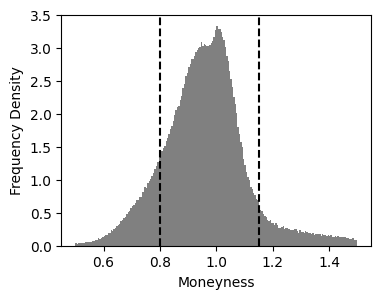

In [161]:
#make a barplot showing the frequency of DTE, show range from 0 to 367 days and make it relative frequency
conc['Moneyness'].plot(kind='hist', bins=200, range=(0.5,1.5), density=True, color='grey', figsize=(4,3))
#set x-axis label
plt.xlabel('Moneyness')
#set y-axis label
plt.ylabel('Frequency Density')
plt.axvline(x=0.8, color='black', linestyle='--')
plt.axvline(x=1.15, color='black', linestyle='--')

Text(0, 0.5, 'Frequency Density')

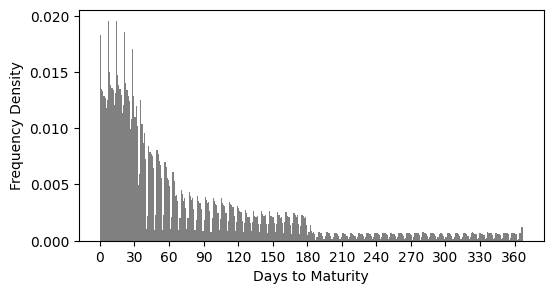

In [162]:
#make a barplot showing the frequency of DTE, show range from 0 to 367 days and make it relative frequency
conc[' [DTE]'].plot(kind='hist', bins=367, range=(0,367), density=True, color='grey', figsize=(6,3))
#set x-axis label
plt.xlabel('Days to Maturity')
#set y-axis label
lbls = np.array([0,30,60,90,120,150,180,210,240,270,300,330,360])
plt.xticks(lbls)
plt.ylabel('Frequency Density')

In [45]:


# conc1,len = helpers.split_days(conc, num_groups = 1)
# 
# conc1 = conc[7]
# daysaddasint = conc1[' [DTE]'].values
# strikes = conc1[' [STRIKE]'].values
# implied_vols = conc1[' [C_IV]'].values

# daysaddasint_unique = np.unique(daysaddasint)

# consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})
# #only use rows and cols with strikes > 0.8*spot and < 1.2*spot and maturities > 0.0 and < 1.0

# #use mean in case of dublicates
# consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


# # Pivot the dataframe to create the matrix
# volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')


25


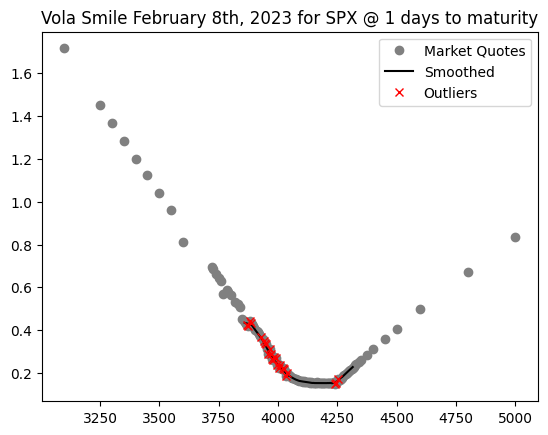

6


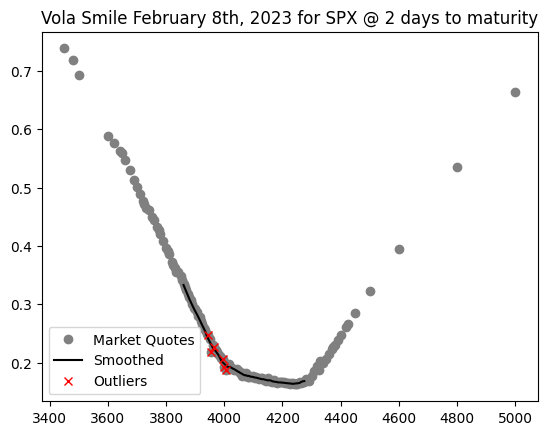

1


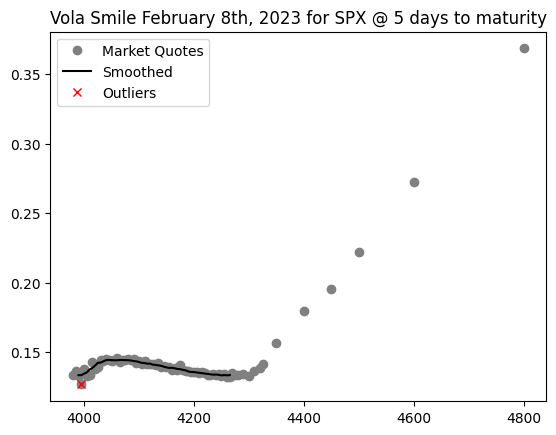

3


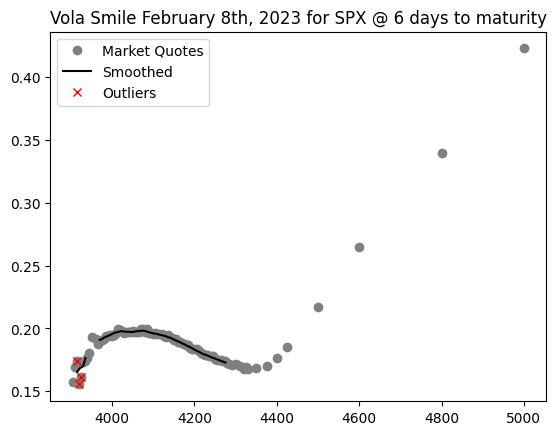

0


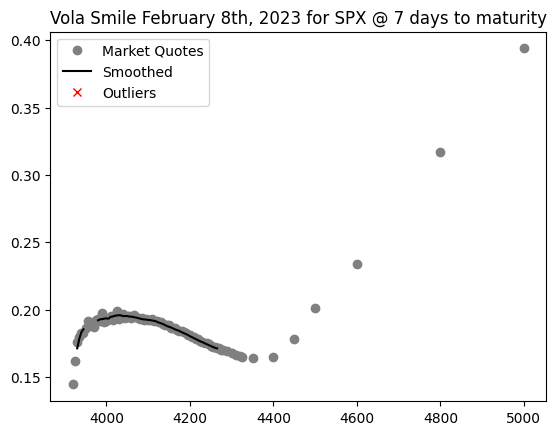

0


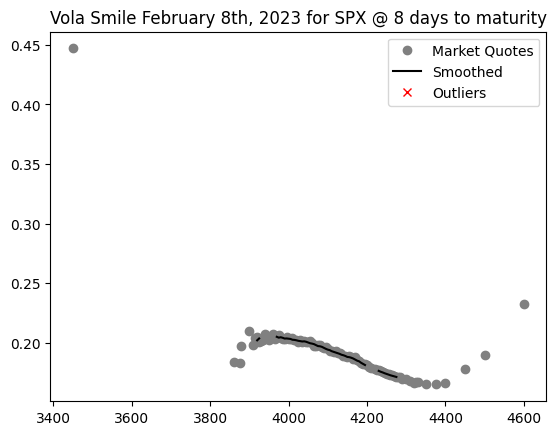

10


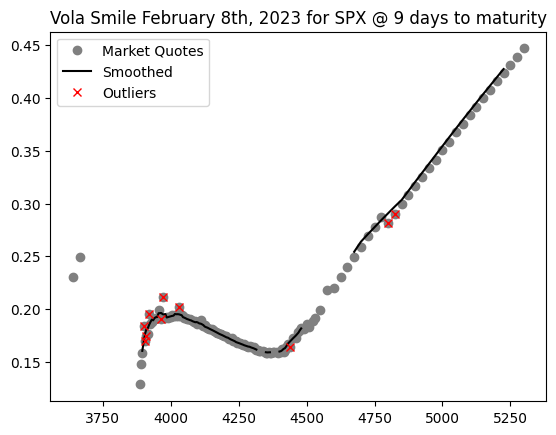

0


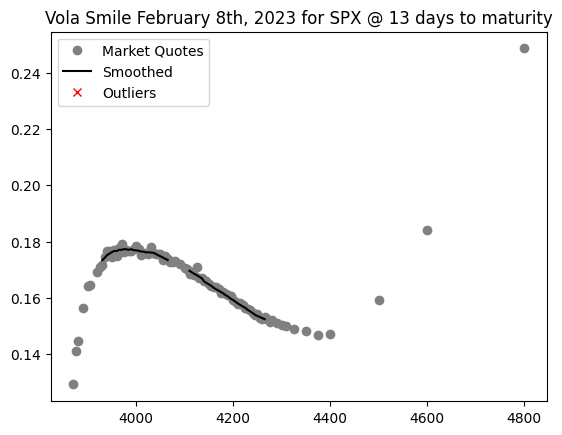

0


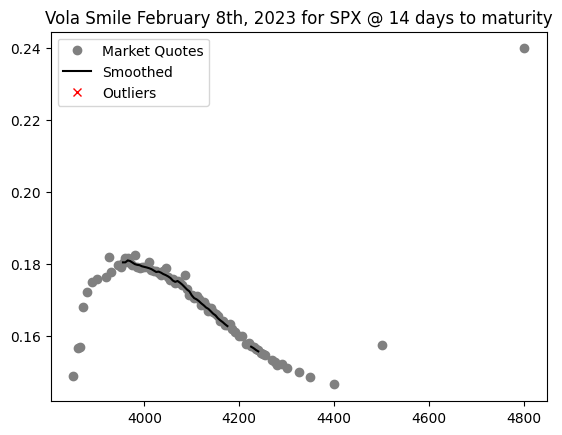

0


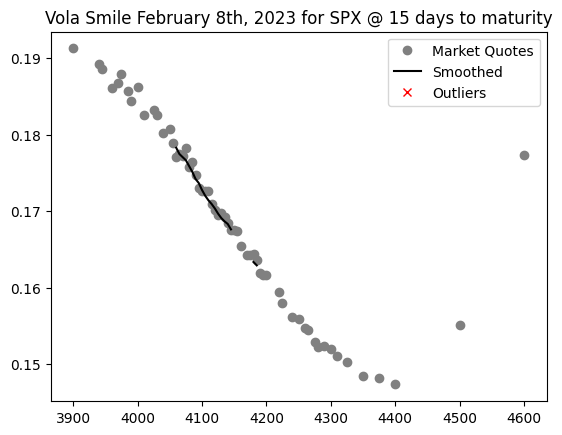

0


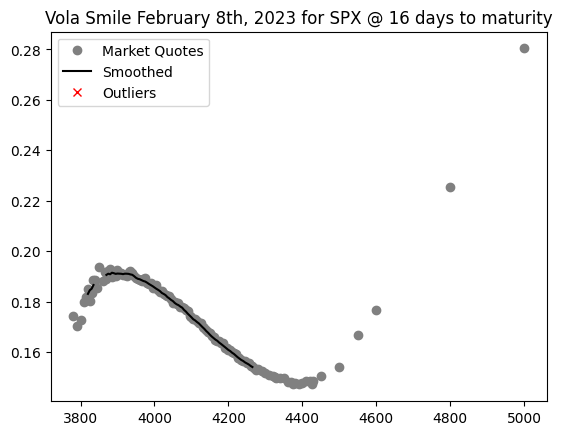

0


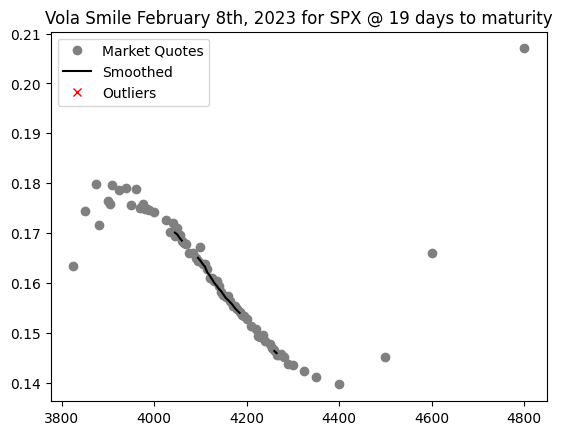

1


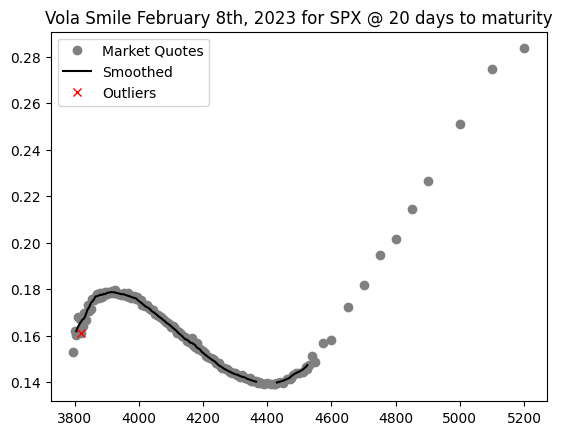

0


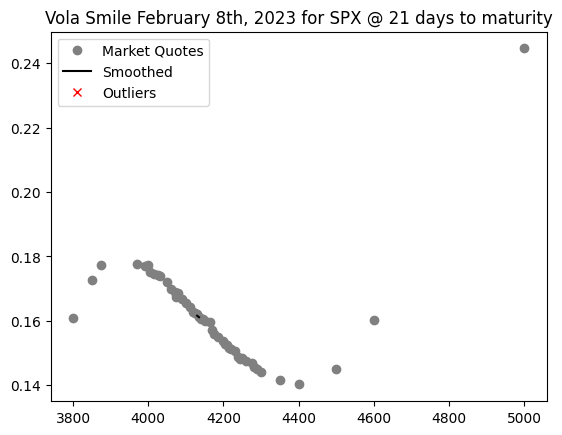

0


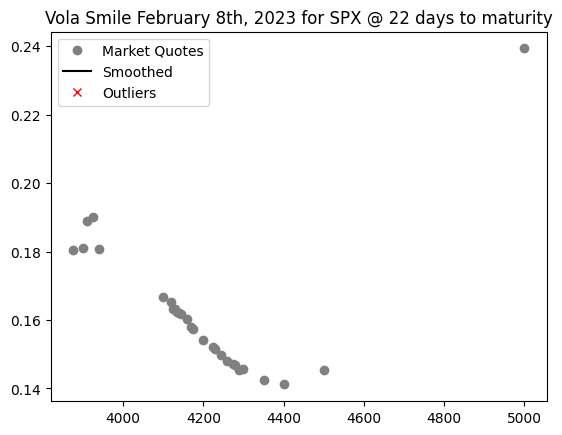

0


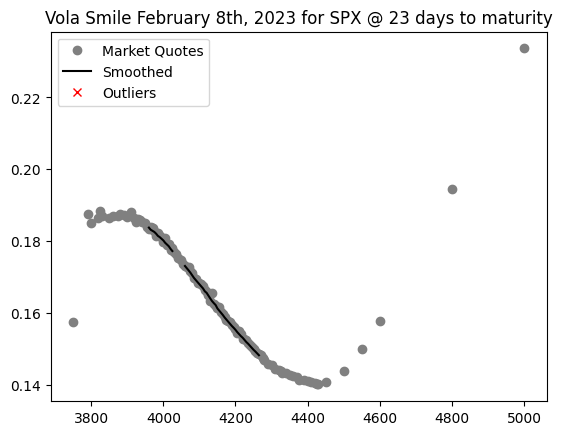

0


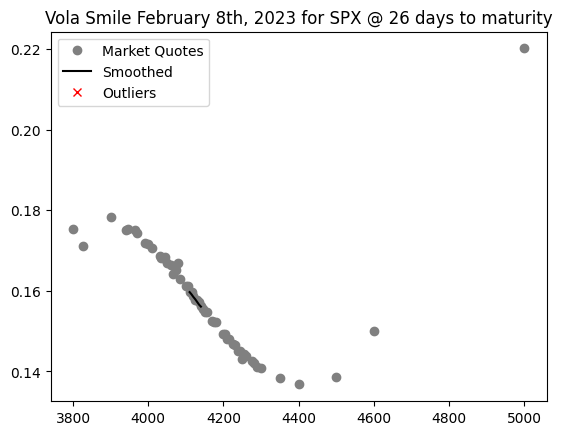

0


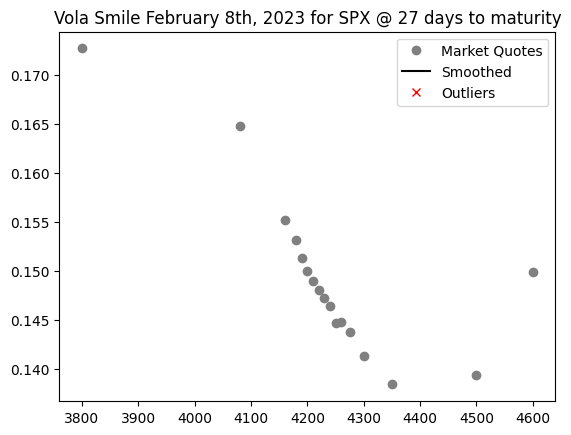

0


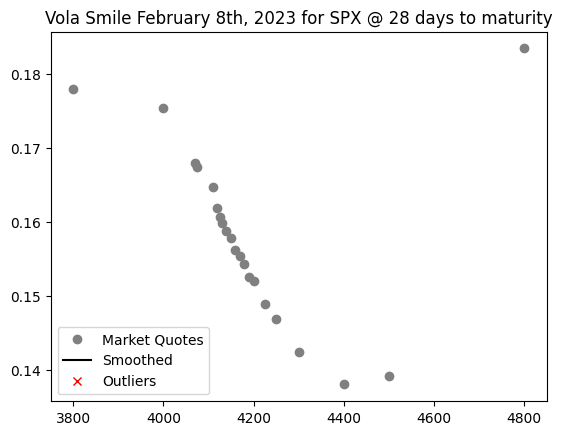

0


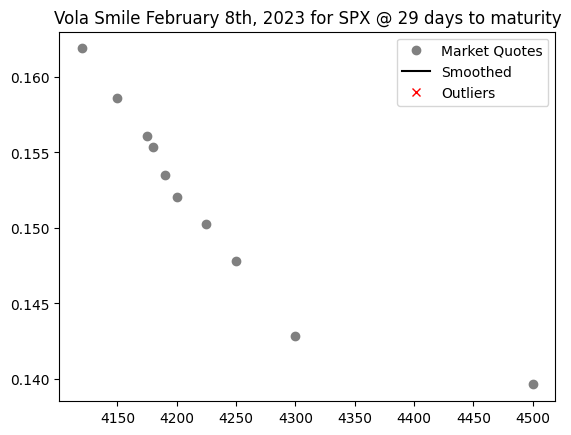

0


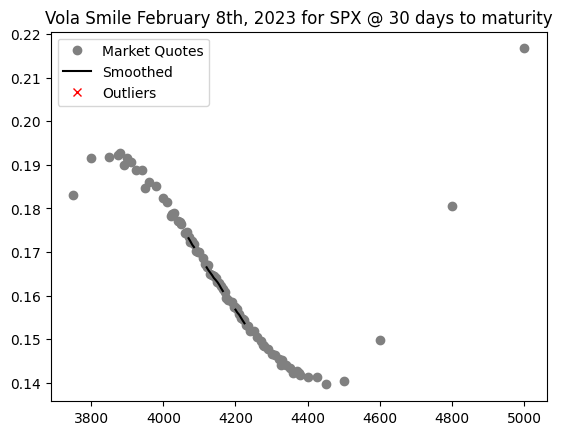

0


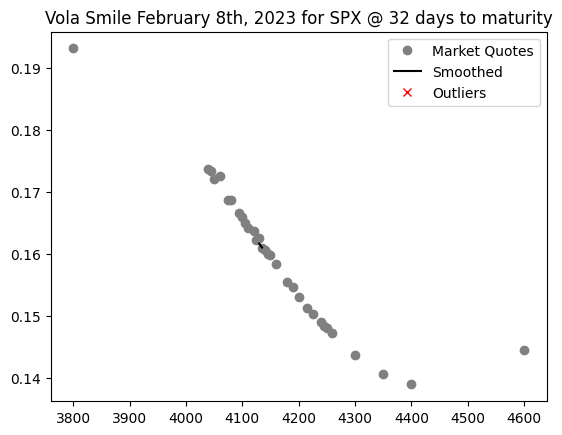

0


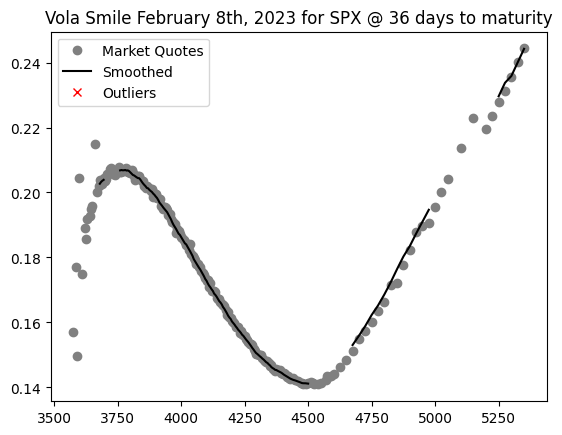

0


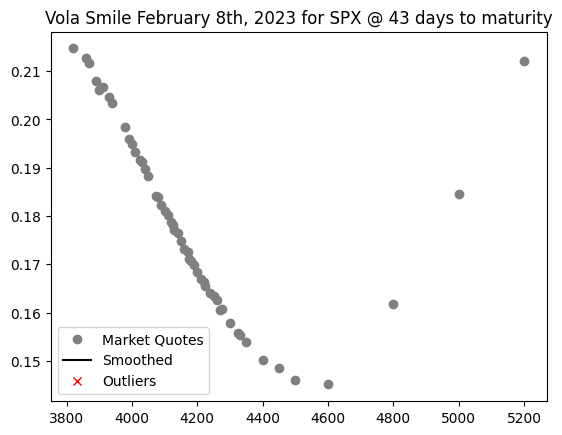

1


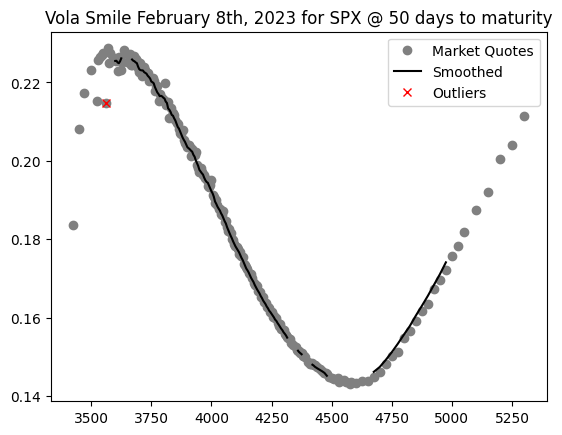

0


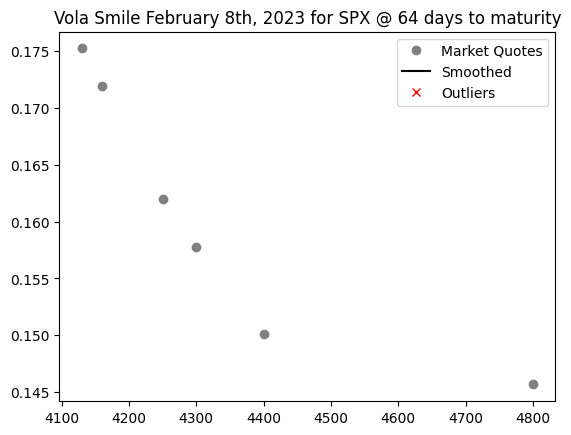

0


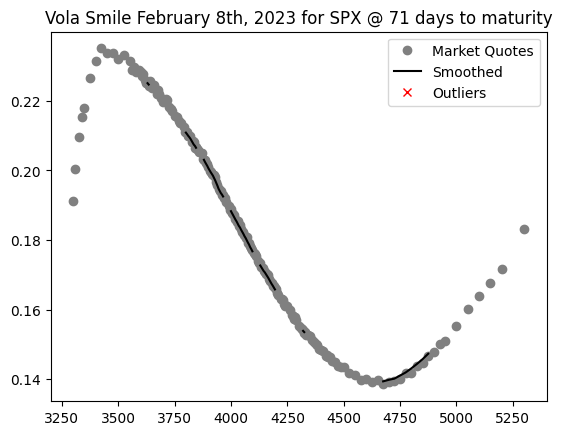

0


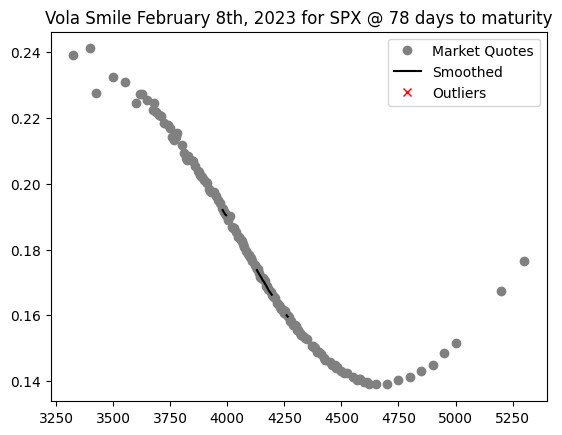

0


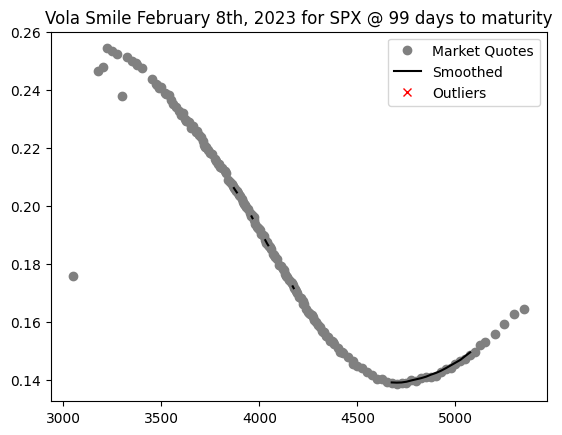

0


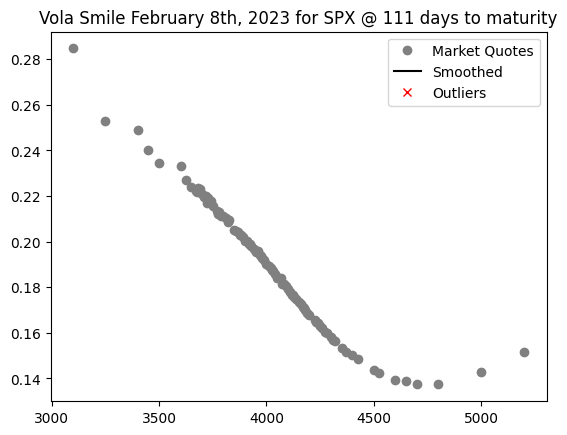

0


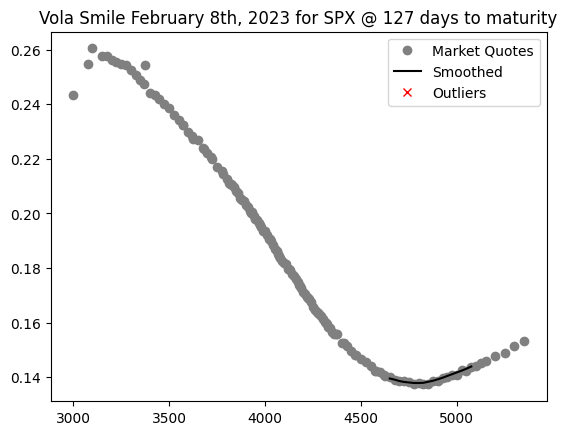

0


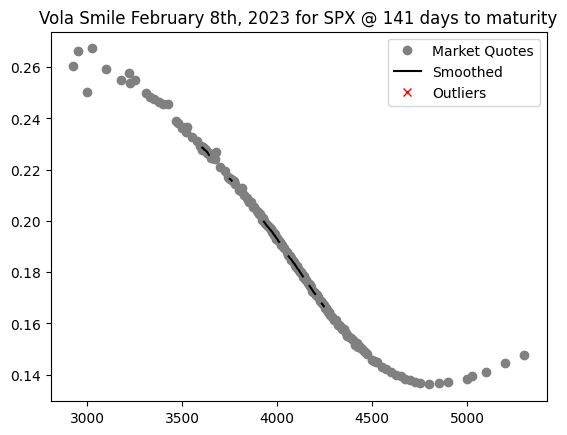

0


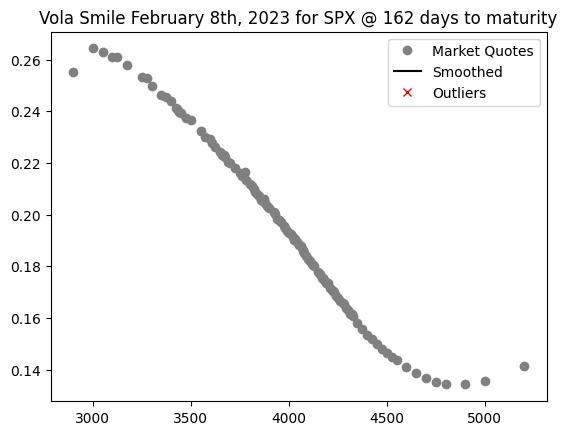

0


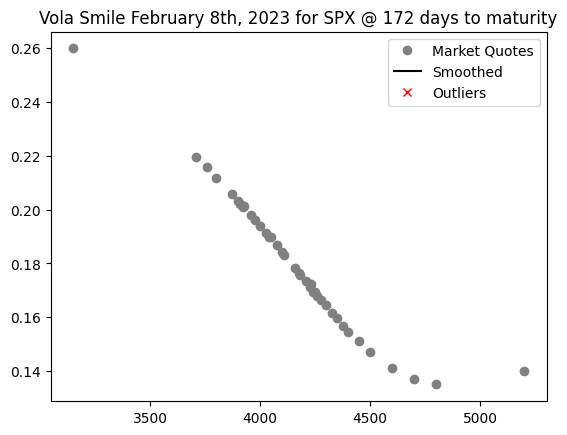

0


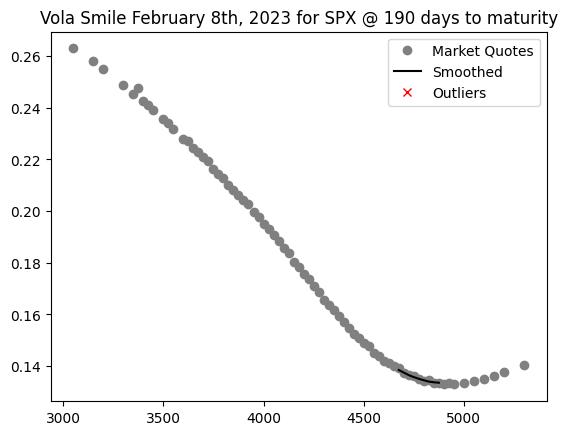

0


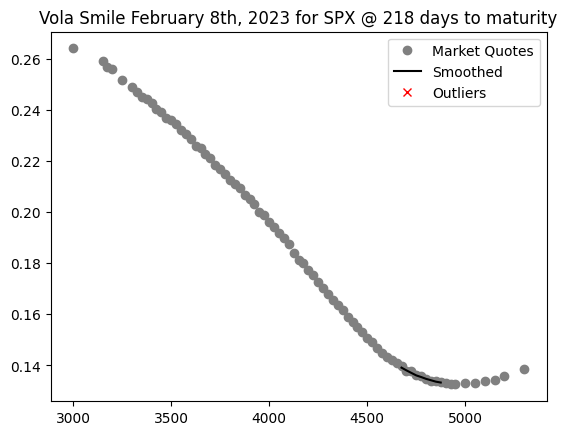

0


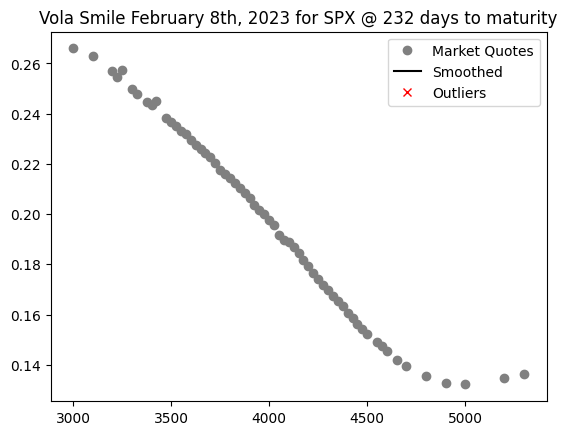

0


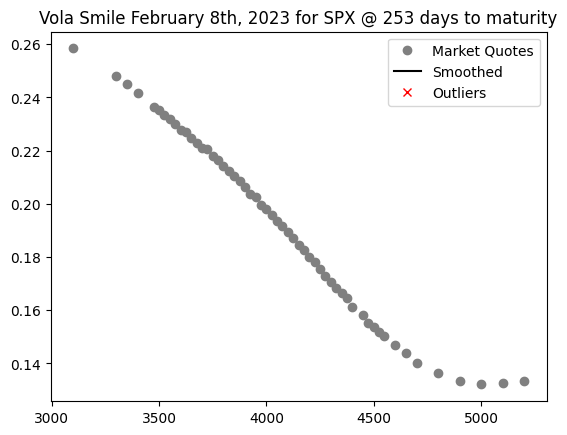

0


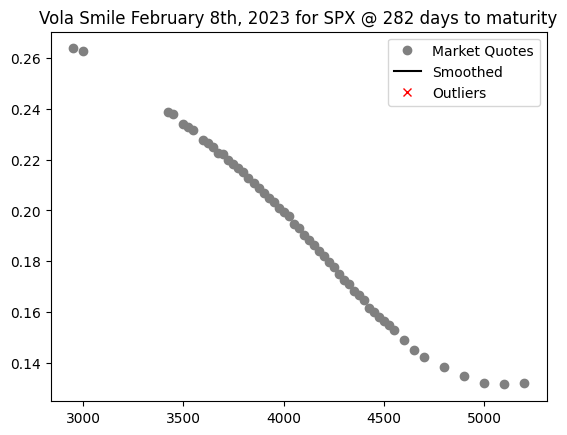

0


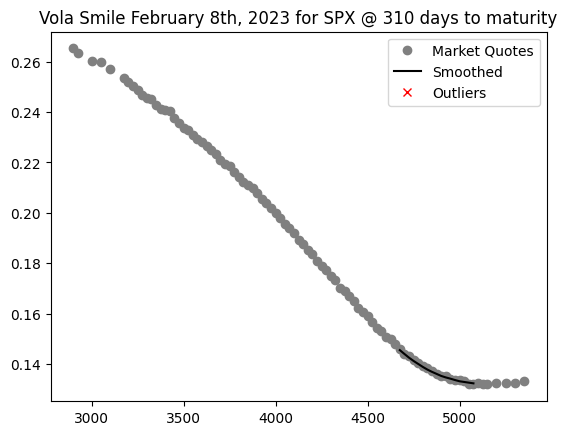

0


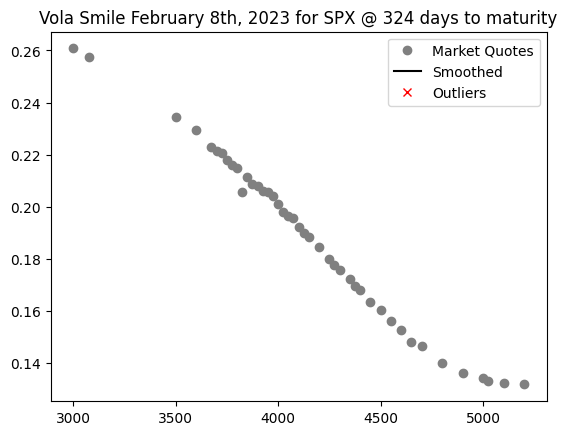

0


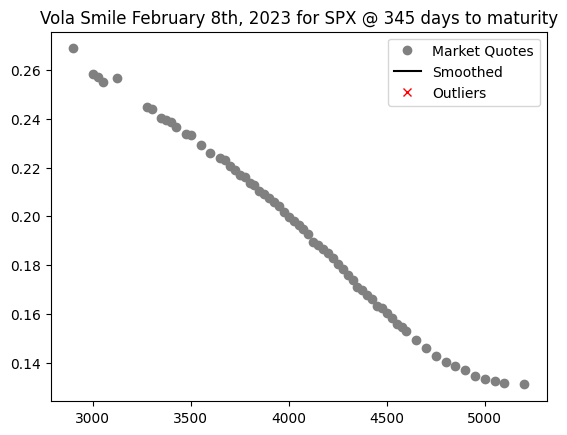

In [21]:
import numpy as np
from scipy.signal import savgol_filter

for i, ds in enumerate(np.array(daysaddasint_unique)):

    first_col = volmatrix1.iloc[:, i]
    # Generate some sample data
    x = first_col.index
    y = first_col.values

    # Smooth the data using a Savitzky-Golay filter
    y_smooth = savgol_filter(y, 6, 1, mode='interp')

    # Calculate the absolute difference between y and y_smooth
    diff = np.abs(y - y_smooth)> 0.005    #this impacts high maturities as they are generally much smoother, base difference is 1.5%
    print(np.count_nonzero(diff))
    # Identify the outliers
    outliers = x[diff]

    # Create new arrays for filtered and outlier values
    y_filtered = np.copy(y)
    y_filtered[diff] = np.nan
    y_outliers = y[diff]

    # Smooth the filtered data using a Savitzky-Golay filter
    y_filtered_smooth = savgol_filter(y_filtered, 6, 1)

    # Plot the results
    import matplotlib.pyplot as plt
    volmatrix.iloc[diff, i] = np.nan
    plt.plot(x, y, 'o', label='Market Quotes', color='gray')
    plt.plot(x, y_smooth, label='Smoothed', color='black')
    plt.plot(outliers, y_outliers, 'rx', label='Outliers')
    plt.title('Vola Smile ' + str(calculation_date) + ' for ' + str('SPX') + ' @ ' + str(ds) + ' days to maturity')
    plt.legend()
    plt.show()



In [43]:
volmatrix1.index = volmatrix1.index.astype(float)/spot

In [44]:
volmatrix1.index = np.log(volmatrix1.index)

In [56]:
#get volmatrix at column "1", plot dots
volmatrix1.iloc[:, 4].plot(color='grey', figsize=(6,3), kind = 'scatter', marker = 'o', s=1)

ValueError: plot kind scatter can only be used for data frames

In [30]:
volmatrix1[:,1]

InvalidIndexError: (slice(None, None, None), 1)

In [ ]:
for i, ds in enumerate(np.array(daysaddasint_unique)):

    first_col = volmatrix1.iloc[:, i]
    # Generate some sample data
    x = first_col.index
    y = first_col.values

    # Plot the smiles all into one plot, larger text size
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(x, y, 'o', label='Market Quotes', color='gray')
    ax.plot(b_0005.index, b_0005.values, marker='o', linestyle='None', label='18d', color='#D1483E', markersize=6)
    ax.plot(b_001.index, b_001.values, marker='o', linestyle='None', label='36d', color='#5977E3', markersize=6)
    ax.plot(b_005.index, b_005.values, marker='o', linestyle='None', label='6M', color='#F49B7C', markersize=6)
    ax.plot(b_010.index, b_010.values, marker='o', linestyle='None', label='1Y', color='#A3C2FE', markersize=6)

    # Dashed lines connecting the data points
    ax.plot(b_0005.index, b_0005.values, linestyle='dashed', color='#D1483E', linewidth=3)
    ax.plot(b_001.index, b_001.values, linestyle='dashed', color='#5977E3', linewidth=3)
    ax.plot(b_005.index, b_005.values, linestyle='solid', color='#F49B7C', linewidth=3)
    ax.plot(b_010.index, b_010.values, linestyle='solid', color='#A3C2FE', linewidth=3)

    ax.legend(loc='upper right', fontsize=14)
    ax.set_xlabel('Log Moneyness', fontsize=20)
    ax.set_ylabel('Implied Volatility', fontsize=20)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    #font size of the ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.show()


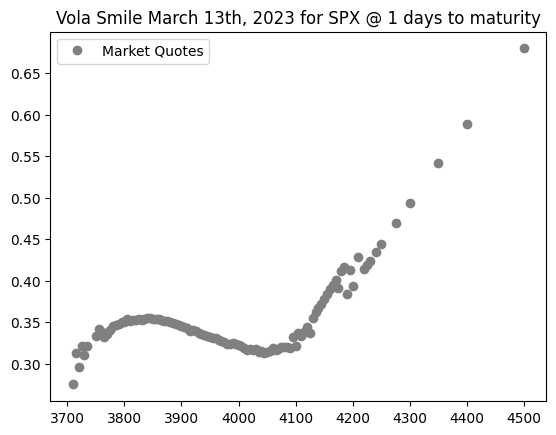

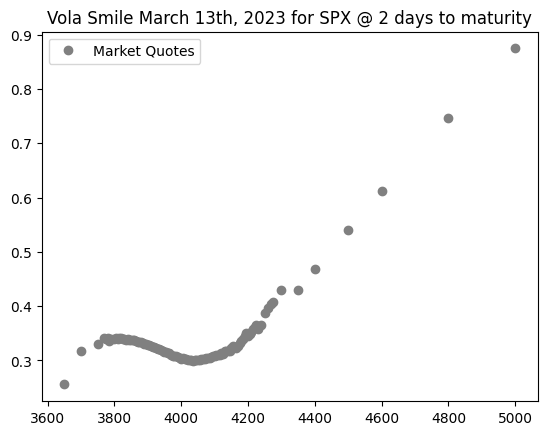

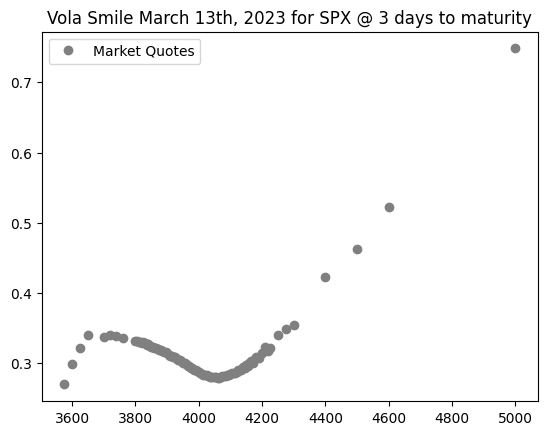

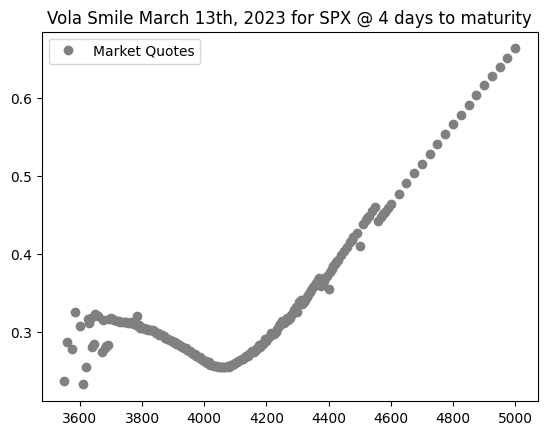

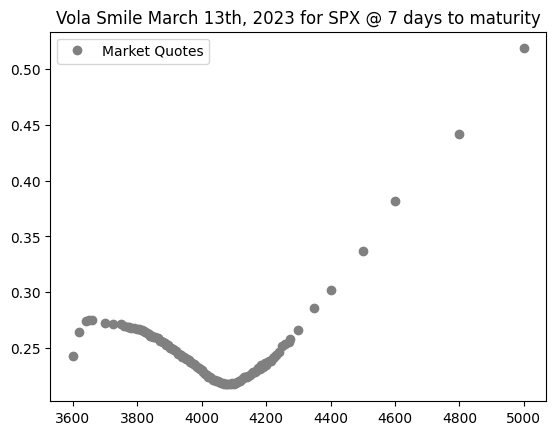

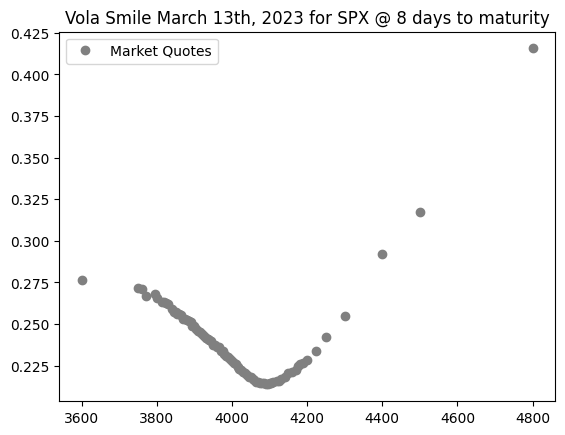

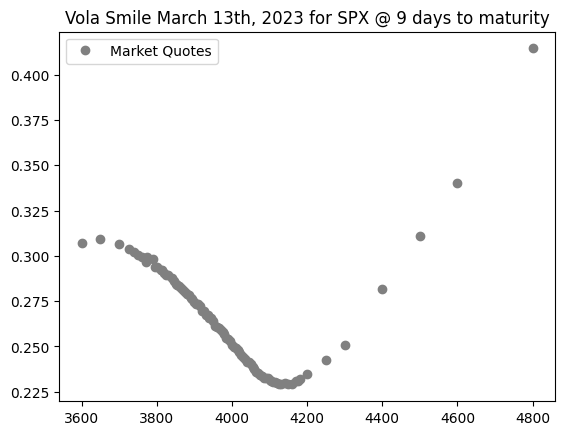

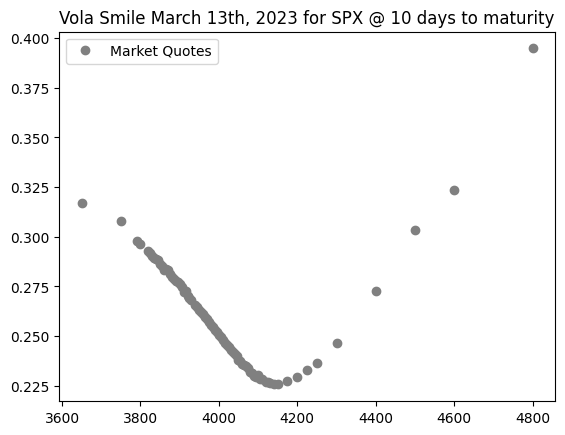

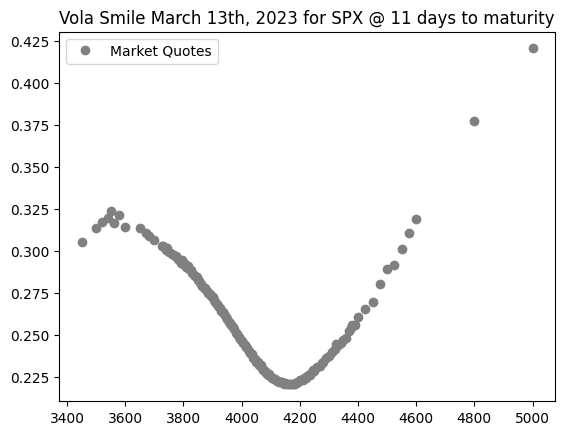

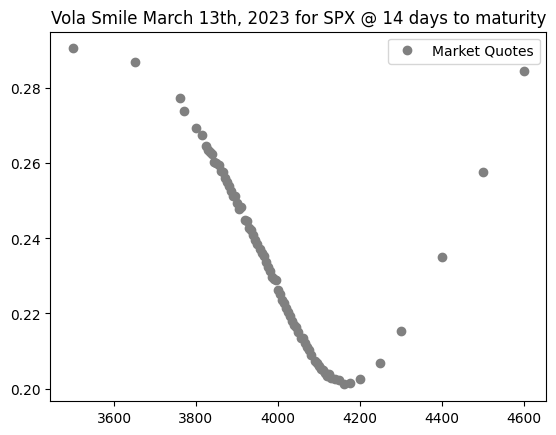

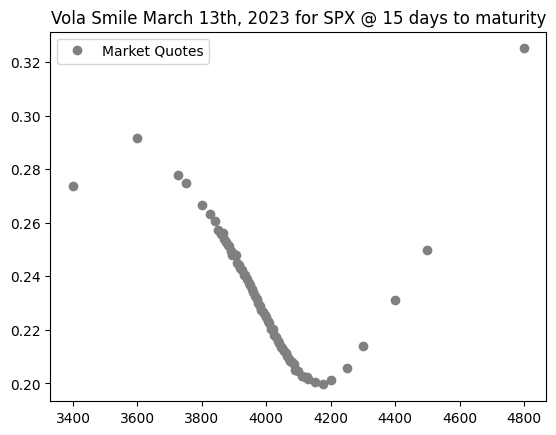

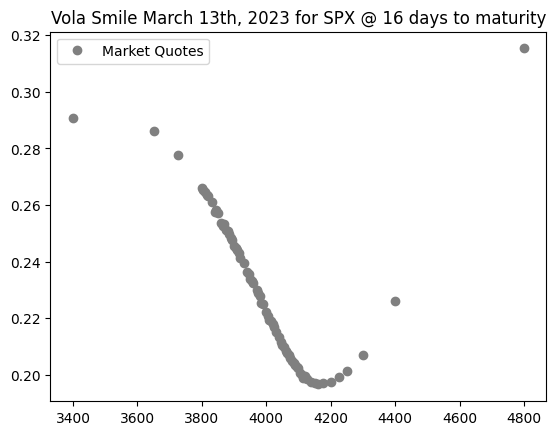

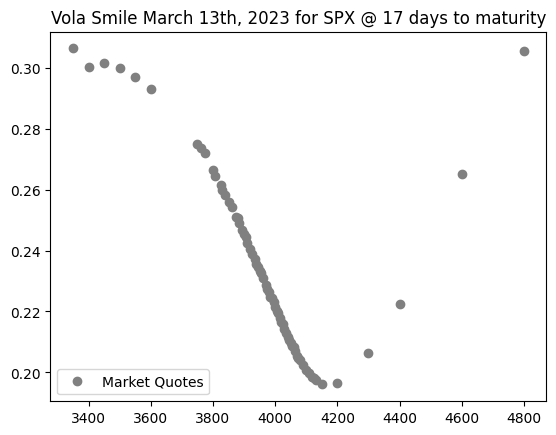

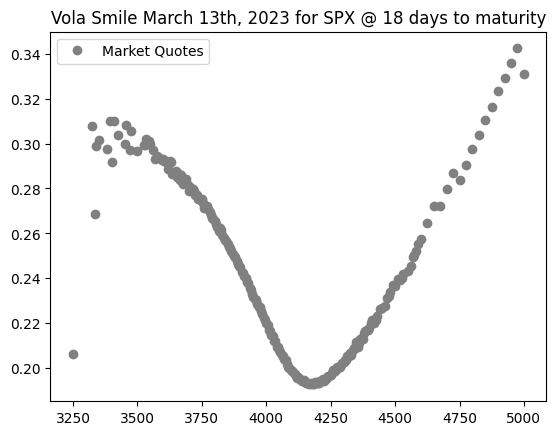

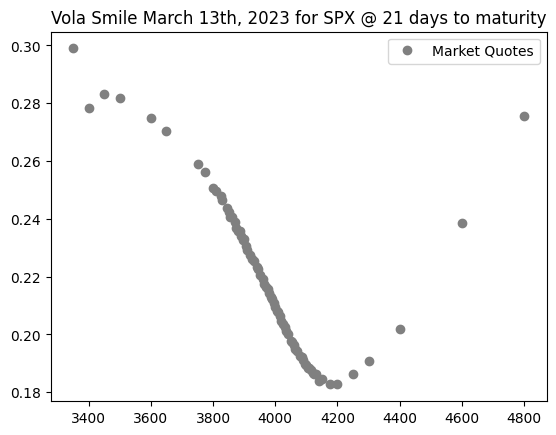

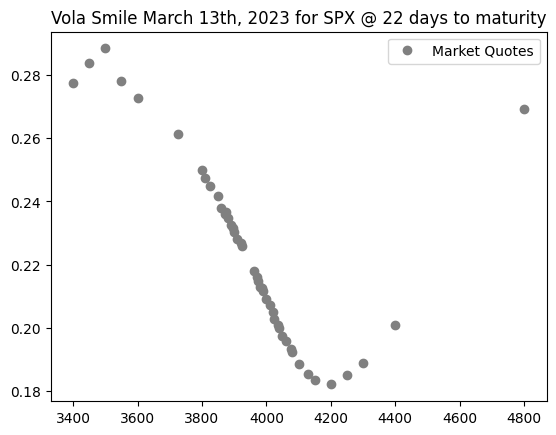

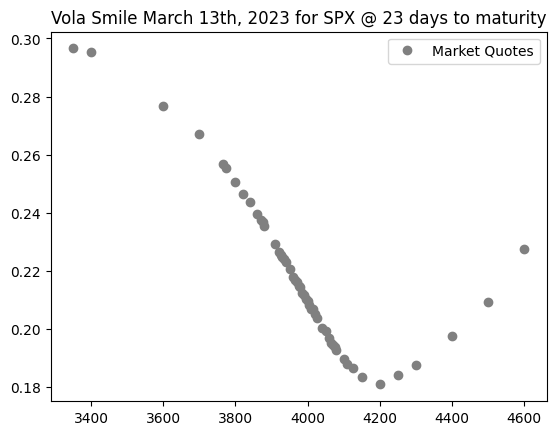

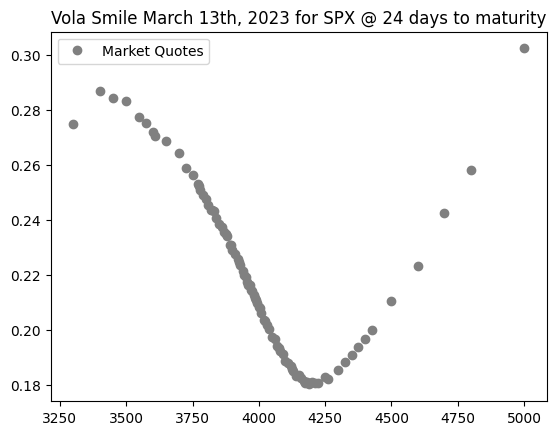

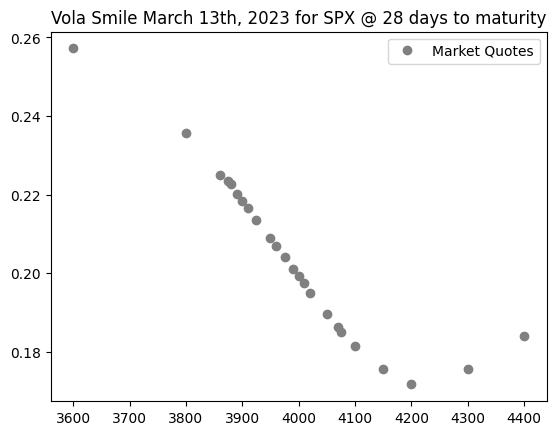

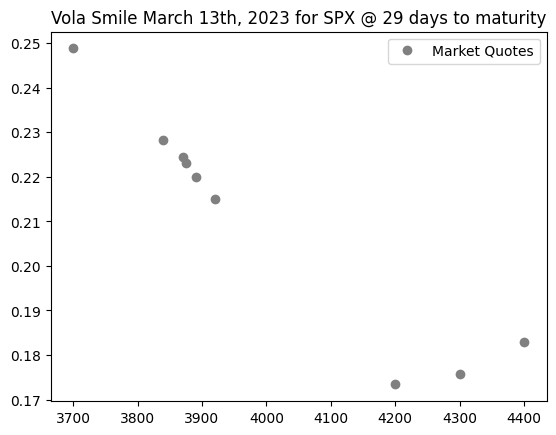

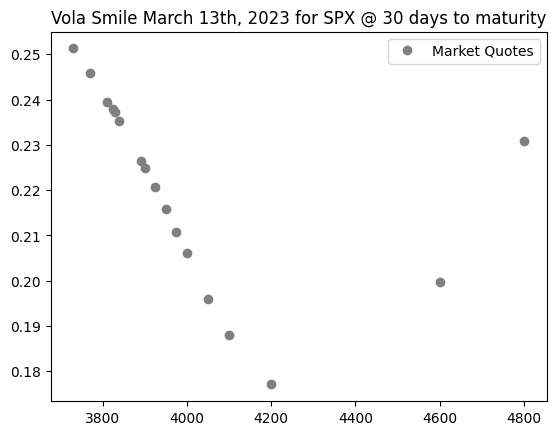

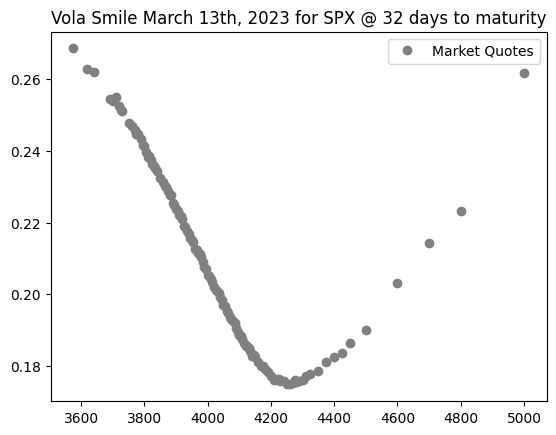

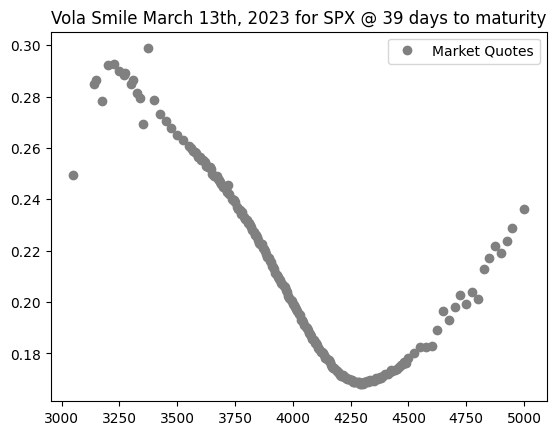

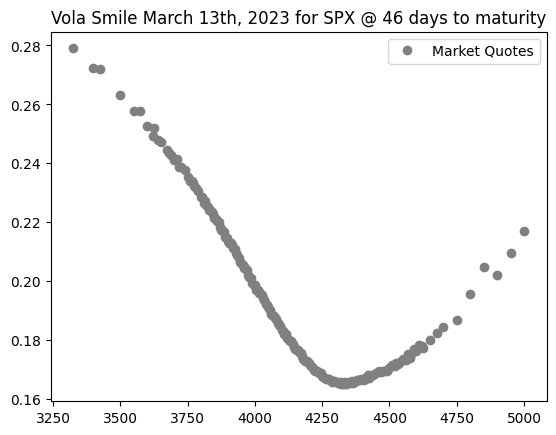

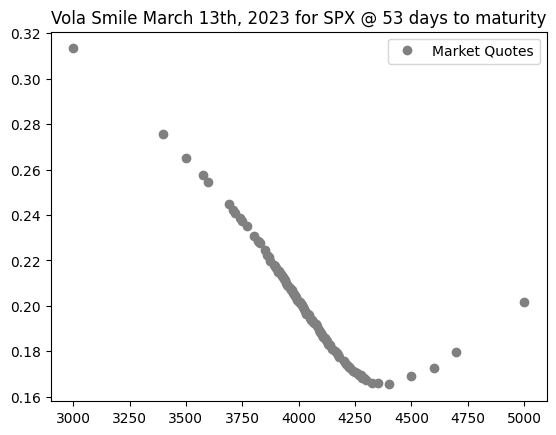

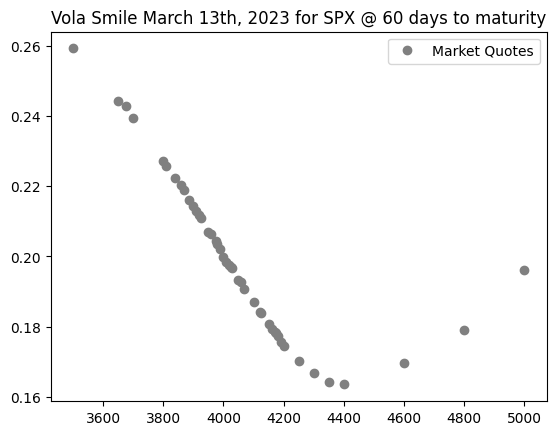

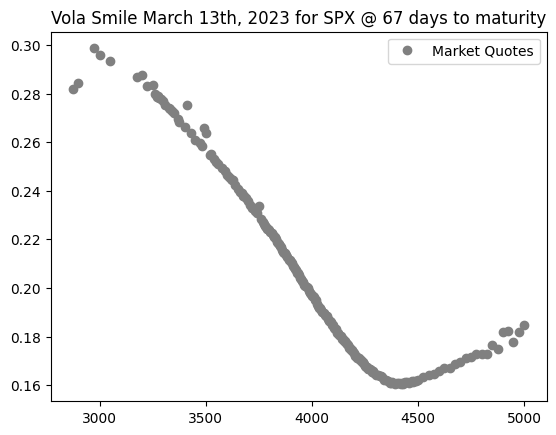

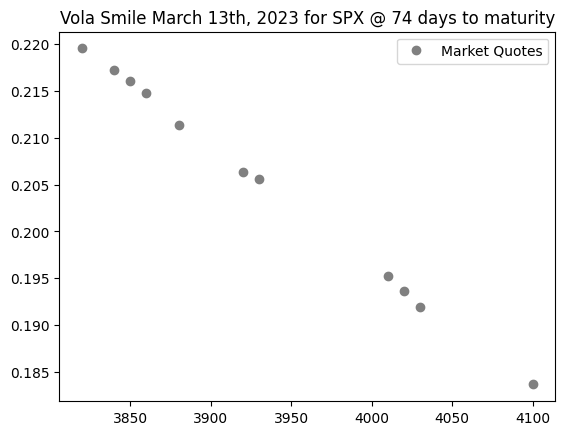

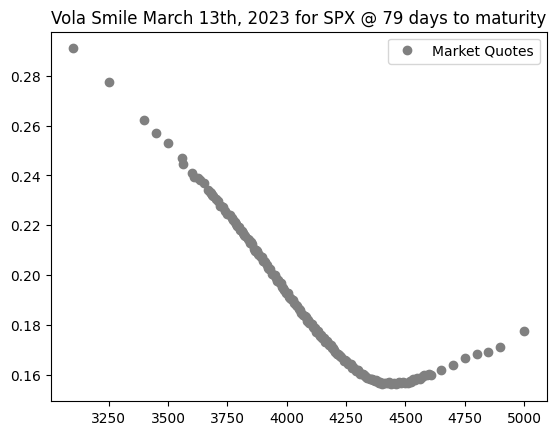

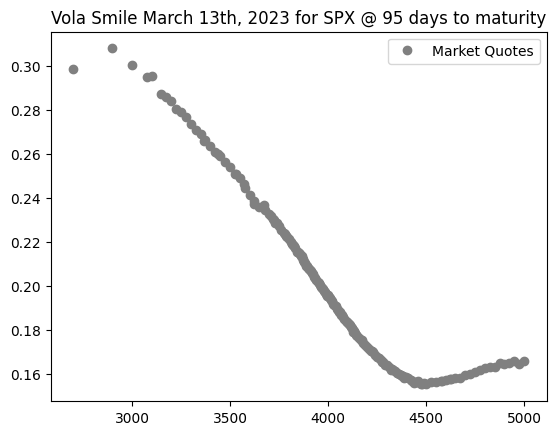

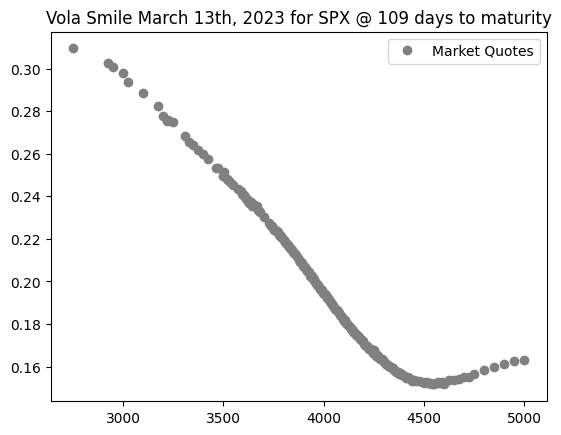

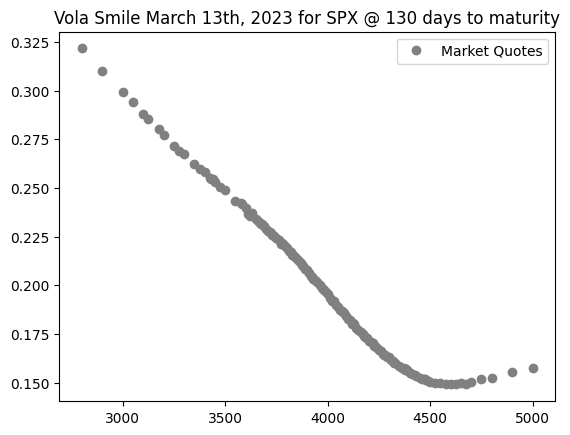

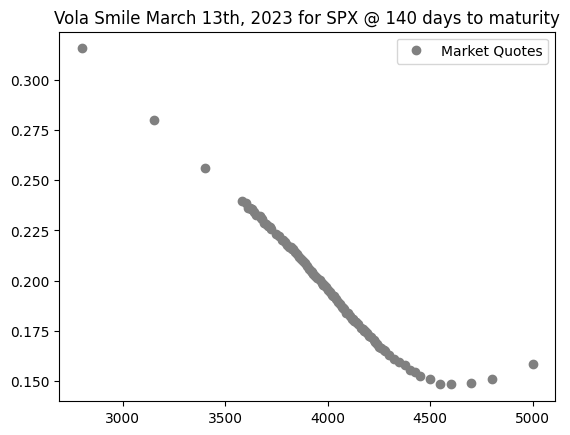

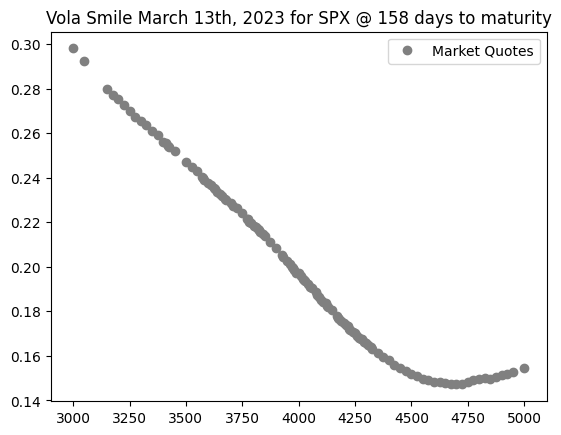

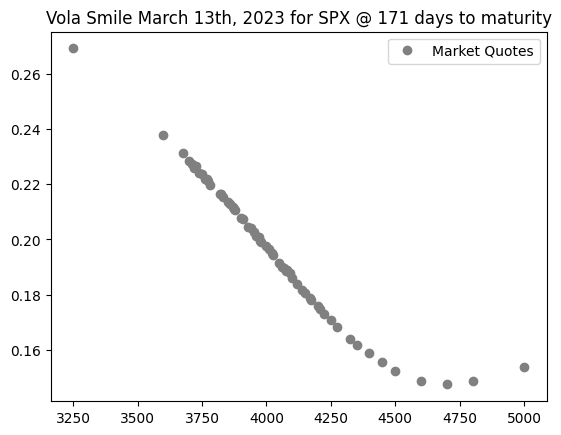

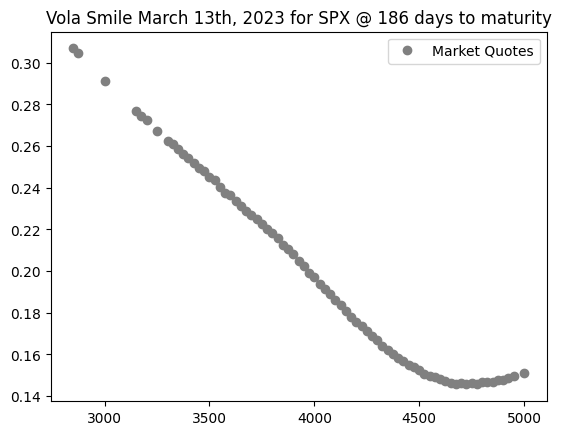

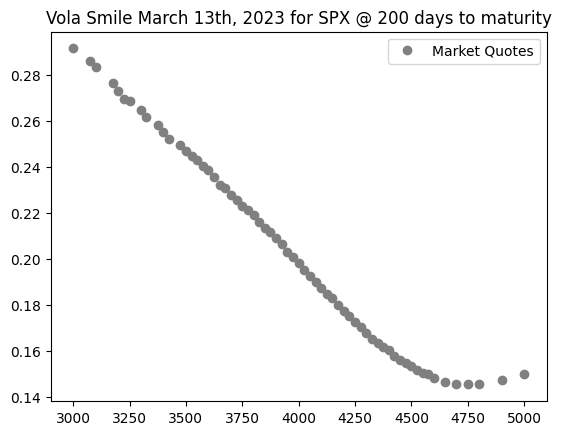

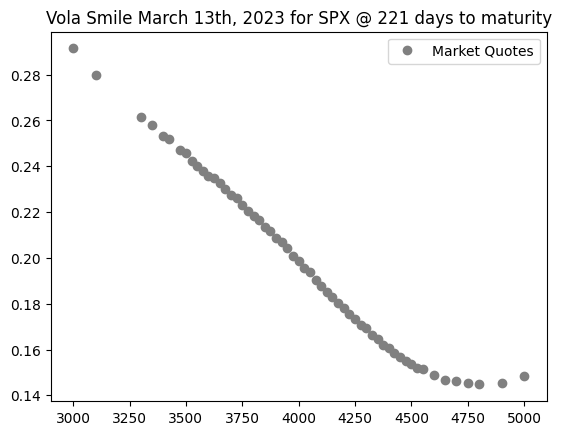

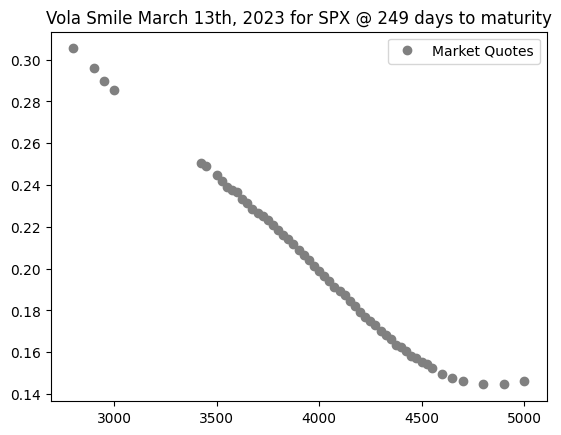

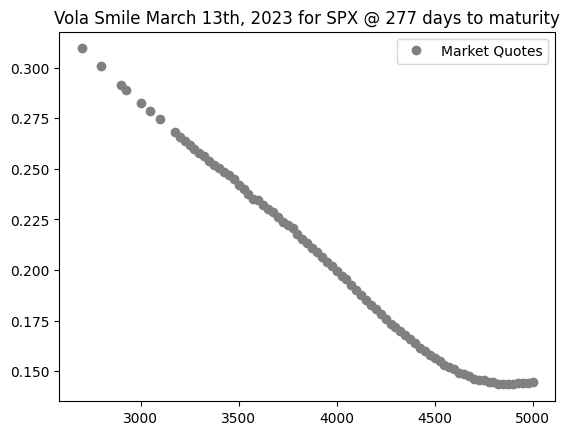

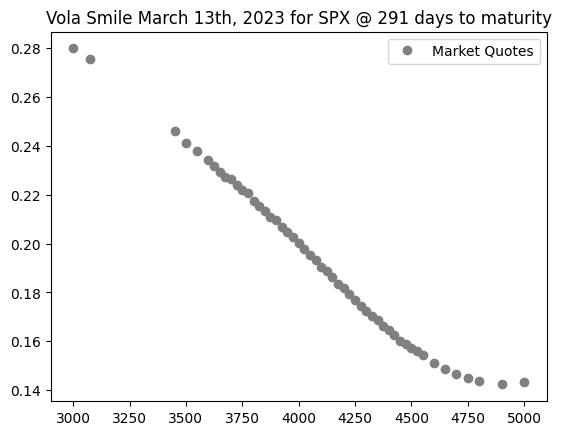

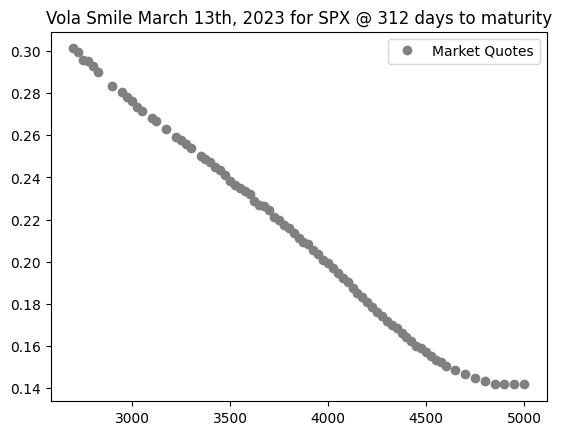

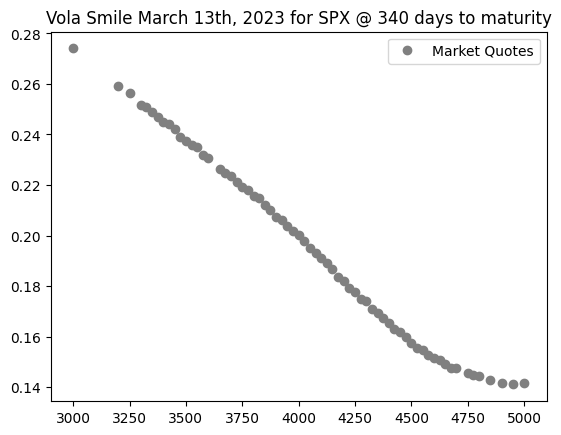

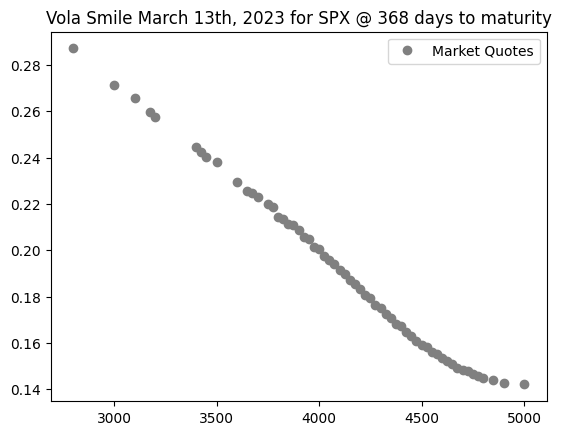

In [26]:
import numpy as np
from scipy.signal import savgol_filter

for i, ds in enumerate(np.array(daysaddasint_unique)):

    first_col = volmatrix1.iloc[:, i]
    # Generate some sample data
    x = first_col.index
    y = first_col.values

    plt.plot(x, y, 'o', label='Market Quotes', color='gray')

    plt.title('Vola Smile ' + str(calculation_date) + ' for ' + str('SPX') + ' @ ' + str(ds) + ' days to maturity')
    plt.legend()
    plt.show()



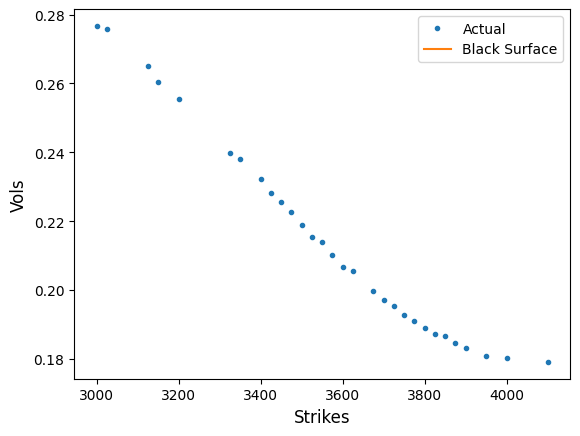

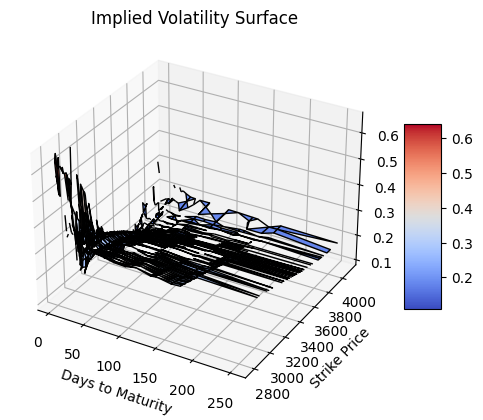

calibrating...


RuntimeError: less functions (1) than available variables (5)

In [13]:
#only use first column of volmatrix
volmatrix = volmatrix.iloc[:, 0:1]


import Quantlib as ql
# dummy parameters
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; sigma = 0.5;
#v0=0.1; kappa=3; theta=0.05; rho=-0.8; sigma=0.3;


#original
process = ql.HestonProcess(flat_ts, dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(spot)), 
                           v0, kappa, theta, sigma, rho)


#original
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model) 



#bicubic
# one_year_idx = 11 # 12th row in data is for 1 year expiry
# date = expiration_dates[5]

heston_helpers = []
strike_helpers = []
maturity_helpers = []

# Heston model calibration
for i, date in enumerate(volmatrix.columns):
    for j, s in enumerate(volmatrix.index):
        t = (date - calculation_date)
        p = ql.Period(t, ql.Days)
        sigma = volmatrix.iloc[j,i]
        if not np.isnan(sigma):
            #sigma = black_var_surface.blackVol(t/365.25, s)
            helper = ql.HestonModelHelper(p, calendar, spot, s, 
                                        ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                        flat_ts, 
                                        dividend_ts)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            strike_helpers.append(s)
            maturity_helpers.append(date)

lm = ql.LevenbergMarquardt(1e-6, 1e-6, 1e-6)
print("Calibrating Heston parameters...")
model.calibrate(heston_helpers, lm, 
                 ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()
lambd = kappa * (1 - rho ** 2) ** 0.5

# for j, s in enumerate(strikes):
#     t = (date - calculation_date )
#     p = ql.Period(t, ql.Days)
#     sigma = data[5][j]
#     #sigma = black_var_surface.blackVol(t/365.25, s)
#     helper = ql.HestonModelHelper(p, calendar, spot, s, 
#                                   ql.QuoteHandle(ql.SimpleQuote(sigma)),
#                                   flat_ts, 
#                                   dividend_ts)
#     helper.setPricingEngine(engine)
#     heston_helpers.append(helper)
avg = []


#print("Maturity, Strike, Market Value, Model Value, %% Error")
print("{:<25} {:<9} {:<15} {:<14} {:}".format("Maturity", "Strike", "Market Value", "Model Value", "% Error"))

difference = []
#attention we look on error in market value, not in implied volatility
for i, opt in enumerate(heston_helpers):
    try:
        err = (opt.modelValue()/opt.marketValue() - 1.0)
    except ZeroDivisionError:
        #options with value 0 are disregarded, this is not a model error => 0
        err = 0
    diff = opt.modelValue() - opt.marketValue()
    difference.append(diff)
    
    print("{:} {:<9.1f} {:<15.2f} {:<14.2f} {:<+7.2%}".format(maturity_helpers[i], round(strike_helpers[i], 2), round(opt.marketValue(), 2), round(opt.modelValue(), 2), err))


    #append error to list
    avg = np.append(avg, abs(err))

print("mean % error: {:.2%}".format(np.mean(avg)))
print("median % error: {:.2%}".format(np.median(avg)))



# Print calibrated parameter values
print("Calibrated Parameter Values:")
print("theta = ", theta)
print("kappa = ", kappa)
print("sigma = ", sigma)
print("rho = ", rho)
print("v0 = ", v0)
